In [1]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials

# Data Preprocessing

In [16]:
# Dataset Path
train_data_dir = './Data/train'  
test_data_dir = './Data/test'

# Generating training data, 10% of data included as validation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.1
)

# generating test data and Normalize
test_datagen = ImageDataGenerator(
    rescale=1./255
)

# Create training data
train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(224, 224),
    batch_size=128,
    class_mode='binary',
    subset='training'
)

# Create validation data
validation_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(224, 224),
    batch_size=128,
    class_mode='binary',
    subset='validation'
)

# Create test data
test_generator = test_datagen.flow_from_directory(
    test_data_dir,
    target_size=(224, 224),
    batch_size=128,
    class_mode='binary',
    shuffle=False
)

Found 90000 images belonging to 2 classes.
Found 10000 images belonging to 2 classes.
Found 20000 images belonging to 2 classes.


# CNN

In [3]:
# Helper function to plot Acc graph
def plot_acc(his,str):
    plt.plot(his.history['accuracy'], label='Training Accuracy')
    plt.plot(his.history['val_accuracy'], label='Validation Accuracy')

    plt.title(str +' Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')

    plt.legend()
    plt.show()

In [4]:
# Construct CNN Model
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),

    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])


model.summary()


history = model.fit(
    train_generator,
    epochs=20,
    validation_data=validation_generator
)
model.save('CNN_model.h5')



Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 111, 111, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 54, 54, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 52, 52, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 26, 26, 128)      0

In [5]:
#运行测试数据结果
test_loss, test_acc = model.evaluate(test_generator)
print('Test accuracy:', test_acc)

157/157 [==============================] - 11s 71ms/step - loss: 0.3948 - accuracy: 0.9258
Test accuracy: 0.925849974155426


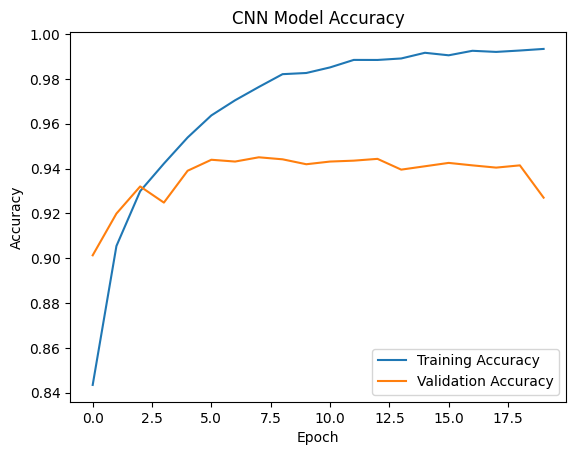

In [6]:
plot_acc(history,"CNN")

# ResNet

In [7]:
# create ResNet model
base_model = ResNet50(weights='resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5', include_top=False, input_shape=(224, 224, 3))

model = tf.keras.Sequential([
    base_model,
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(1024, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.04, momentum=0.9),
              loss='binary_crossentropy',
              metrics=['accuracy'])

history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.n // 128,
    epochs=20,
    validation_data=validation_generator,
    validation_steps=validation_generator.n // 128
)



Epoch 1/20
703/703 [==============================] - 173s 240ms/step - loss: 0.8496 - accuracy: 0.5832 - val_loss: 0.6810 - val_accuracy: 0.5695
Epoch 2/20
703/703 [==============================] - 168s 239ms/step - loss: 0.6444 - accuracy: 0.6147 - val_loss: 0.6350 - val_accuracy: 0.6070
Epoch 3/20
703/703 [==============================] - 168s 239ms/step - loss: 0.6261 - accuracy: 0.6416 - val_loss: 0.6013 - val_accuracy: 0.6685
Epoch 4/20
703/703 [==============================] - 168s 239ms/step - loss: 0.6067 - accuracy: 0.6712 - val_loss: 0.5911 - val_accuracy: 0.6862
Epoch 5/20
703/703 [==============================] - 168s 239ms/step - loss: 0.5918 - accuracy: 0.6856 - val_loss: 0.5858 - val_accuracy: 0.6887
Epoch 6/20
703/703 [==============================] - 168s 239ms/step - loss: 0.5322 - accuracy: 0.7366 - val_loss: 0.4933 - val_accuracy: 0.7633
Epoch 7/20
703/703 [==============================] - 168s 239ms/step - loss: 0.4195 - accuracy: 0.8126 - val_loss: 0.8137 -

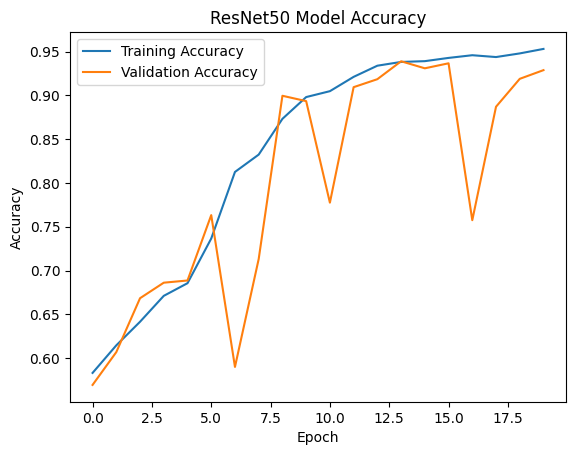

In [8]:
plot_acc(history,"ResNet50")

In [9]:

test_loss, test_acc = model.evaluate(test_generator)
print('Test accuracy:', test_acc)

157/157 [==============================] - 11s 68ms/step - loss: 0.1952 - accuracy: 0.9235
Test accuracy: 0.9235000014305115


# Data Augmentation

In [10]:
# File Path
train_data_dir = './Data/train'
test_data_dir = './Data/test'

enhanced_train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.1
)

enhanced_test_datagen = ImageDataGenerator(rescale=1./255)

enhanced_train_generator = enhanced_train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    subset='training'
)

enhanced_validation_generator = enhanced_train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    subset='validation'
)

enhanced_test_generator = enhanced_test_datagen.flow_from_directory(
    test_data_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    shuffle=False
)


Found 90000 images belonging to 2 classes.
Found 10000 images belonging to 2 classes.
Found 20000 images belonging to 2 classes.


# CNN with Data Augmentation

In [11]:
model = Sequential([

    Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),

    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),

    Flatten(),

    Dense(512, activation='relu'),
    Dropout(0.5),

    Dense(1, activation='sigmoid')
])


model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])


model.summary()


enhanced_history = model.fit(
    enhanced_train_generator,
    epochs=10,
    validation_data=enhanced_validation_generator
)


model.save('enhanced_model.h5')



Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 111, 111, 32)     0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 54, 54, 64)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 52, 52, 128)       73856     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 26, 26, 128)     

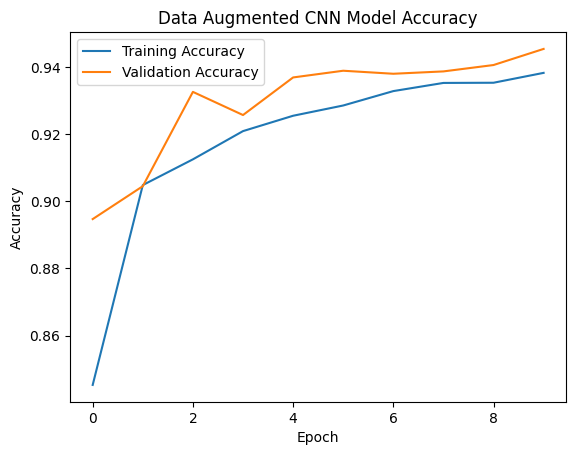

In [15]:
plot_acc(enhanced_history,"Data Augmented CNN")

In [18]:
test_loss, test_acc = model.evaluate(enhanced_test_generator)
print('Test accuracy:', test_acc)

625/625 [==============================] - 64s 102ms/step - loss: 0.1438 - accuracy: 0.9450
Test accuracy: 0.9449999928474426


# Hyperparameter Tuning

In [17]:
def cnn_model(params):
    model = Sequential()

    model.add(Conv2D(int(params['conv1_filters']), (3, 3), activation='relu', input_shape=(224, 224, 3)))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(int(params['conv2_filters']), (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(int(params['conv3_filters']), (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))


    model.add(Flatten())
    model.add(Dense(int(params['dense_units']), activation='relu'))
    model.add(Dropout(params['dropout']))
    model.add(Dense(1, activation='sigmoid'))


    model.compile(loss='binary_crossentropy', optimizer='Adam', metrics=['accuracy'])

    model.fit(
        train_generator,
        epochs=7,
        validation_data=validation_generator,
        verbose=0
    )

    # validation
    val_loss, val_acc = model.evaluate(validation_generator, verbose=0)
    print('Validation Accuracy:', val_acc)

    return {'loss': -val_acc, 'status': STATUS_OK}


#define hyper-parameter
space = {
    'conv1_filters': hp.choice('conv1_filters', [16, 32, 64]),
    'conv2_filters': hp.choice('conv2_filters', [32, 64, 128]),
    'conv3_filters': hp.choice('conv3_filters', [64, 128, 256]),
    'dense_units': hp.choice('dense_units', [256, 512, 1024]),
    'dropout': hp.uniform('dropout', 0, 0.5)
}



trials = Trials()
best = fmin(cnn_model, space, algo=tpe.suggest, max_evals=10, trials=trials)

print('The best Params：', best)

Validation Accuracy:                                  
0.9398999810218811                                    
Validation Accuracy:                                                              
0.9423999786376953                                                                
Validation Accuracy:                                                              
0.928600013256073                                                                 
Validation Accuracy:                                                              
0.9480999708175659                                                                
Validation Accuracy:                                                              
0.9386000037193298                                                                
Validation Accuracy:                                                              
0.9387999773025513                                                                
Validation Accuracy:                                        

# Tunned CNN

In [27]:
model_T = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(32, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),

    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.4221593171862731),
    Dense(1, activation='sigmoid')
])

model_T.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])


model_T.summary()


history_T = model_T.fit(
    train_generator,
    epochs=20,
    validation_data=validation_generator
)

Model: "sequential_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_51 (Conv2D)          (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d_51 (MaxPoolin  (None, 111, 111, 32)     0         
 g2D)                                                            
                                                                 
 conv2d_52 (Conv2D)          (None, 109, 109, 32)      9248      
                                                                 
 max_pooling2d_52 (MaxPoolin  (None, 54, 54, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_53 (Conv2D)          (None, 52, 52, 64)        18496     
                                                                 
 max_pooling2d_53 (MaxPoolin  (None, 26, 26, 64)     

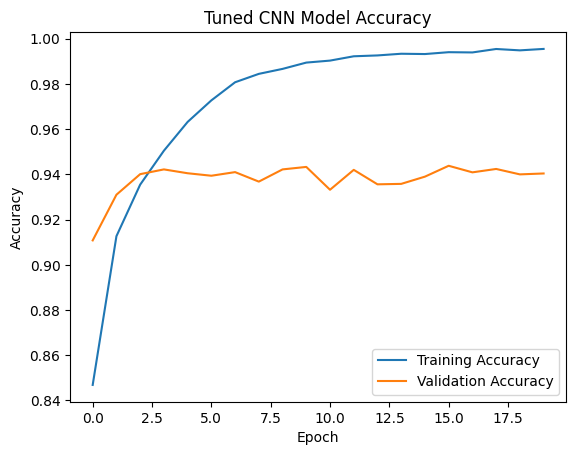

In [28]:
plot_acc(history_T,"Tuned CNN")

In [29]:
test_loss, test_acc = model_T.evaluate(test_generator)
print('Test accuracy:', test_acc)

157/157 [==============================] - 11s 69ms/step - loss: 0.3150 - accuracy: 0.9401
Test accuracy: 0.9401000142097473


In [30]:
# applying Early Stop to avoid over fitting
from keras.callbacks import EarlyStopping
model_T = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(32, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),

    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.4221593171862731),
    Dense(1, activation='sigmoid')
])

model_T.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])



early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=3,
    verbose=1,
    restore_best_weights=True  #
)

history_T = model_T.fit(
    train_generator,
    epochs=20,
    validation_data=validation_generator,
    callbacks=[early_stopping]
)

Epoch 1/20
704/704 [==============================] - 54s 76ms/step - loss: 0.3536 - accuracy: 0.8485 - val_loss: 0.2266 - val_accuracy: 0.9078
Epoch 2/20
704/704 [==============================] - 54s 76ms/step - loss: 0.2175 - accuracy: 0.9122 - val_loss: 0.1990 - val_accuracy: 0.9205
Epoch 3/20
704/704 [==============================] - 54s 77ms/step - loss: 0.1718 - accuracy: 0.9334 - val_loss: 0.1591 - val_accuracy: 0.9388
Epoch 4/20
704/704 [==============================] - 54s 77ms/step - loss: 0.1424 - accuracy: 0.9448 - val_loss: 0.1530 - val_accuracy: 0.9441
Epoch 5/20
704/704 [==============================] - 55s 78ms/step - loss: 0.1116 - accuracy: 0.9579 - val_loss: 0.1566 - val_accuracy: 0.9396
Epoch 6/20
704/704 [==============================] - 53s 76ms/step - loss: 0.0829 - accuracy: 0.9688 - val_loss: 0.1675 - val_accuracy: 0.9394
Epoch 7/20
704/704 [==============================] - 55s 78ms/step - loss: 0.0620 - accuracy: 0.9772 - val_loss: 0.1973 - val_accuracy:

In [31]:
test_loss, test_acc = model_T.evaluate(test_generator)
print('Test accuracy:', test_acc)

157/157 [==============================] - 11s 69ms/step - loss: 0.1638 - accuracy: 0.9361
Test accuracy: 0.9361000061035156
